# Demo2 of CubeNet
A simple example of how to use CubeNet to directly pick P/S arrivals from a given cube

In [1]:
import sys; sys.path.append('../../'); # To import CubeNet
import torch
import CubeNet

import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load Seismograms and Stations

In [2]:
# Load Prepared waveform file
data_dict = np.load('Cube.npz');
data = data_dict['cube'];
# Dimension of cube data: batch size, channel (X/Y/Z), dx, dy, sampling points
print('Shape of cube data:',data.shape);

Shape of cube data: (1, 3, 8, 8, 6000)


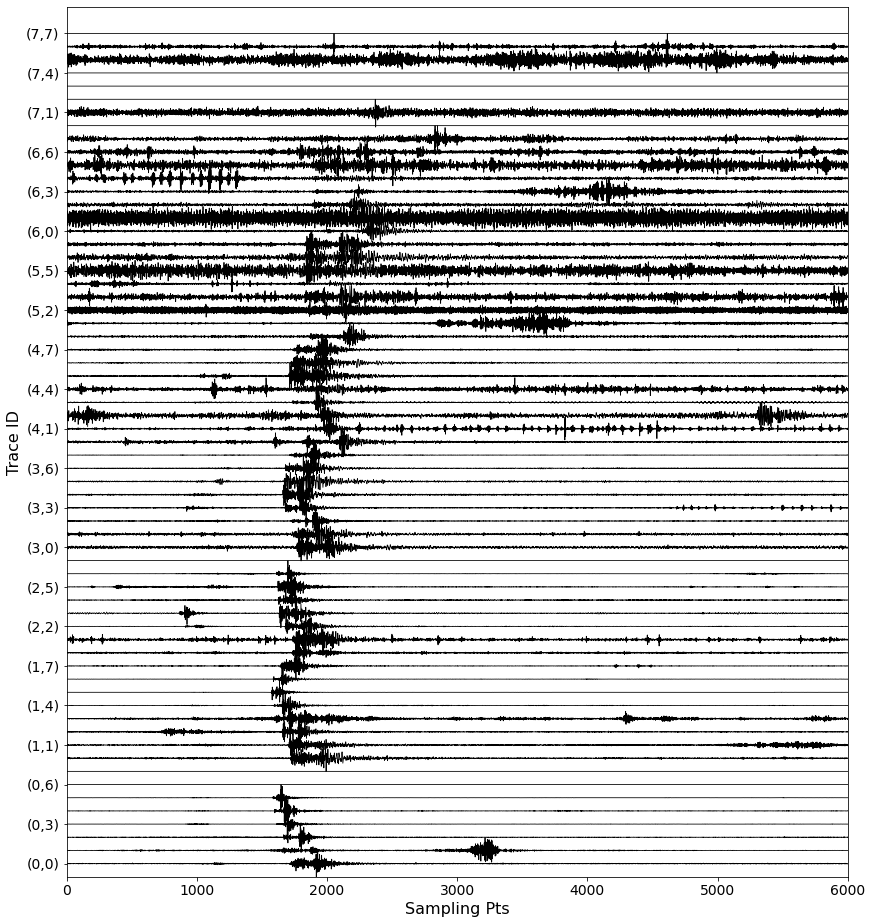

In [3]:
# Look at seismograms (Z component)
plt.figure(figsize=(14,16))
counter = 0; ytick_lst = [];
for i in range(data.shape[2]):
    for ii in range(data.shape[3]):
        ytick_lst.append('(' + str(i) + ',' + str(ii) + ')');
        plt.plot(counter + data[0,2,i,ii,:]/(max(data[0,2,i,ii,:]) + 1e-12) , 'k' ,lw=0.8);
        counter += 1;
plt.xlim([0,data.shape[-1]]);plt.xticks(fontsize=14);plt.xlabel('Sampling Pts',fontsize=16);
plt.ylim([-1,data.shape[2]**2+1]);plt.yticks(fontsize=14);plt.ylabel('Trace ID',fontsize=16);
plt.yticks(np.arange(0,64,3,dtype=int),ytick_lst[slice(0,64,3)]);

## Step 2: Put them in given API

In [4]:
# convert data to torch Tensor
torch_data = torch.Tensor(data);

In [6]:
# Using CubeNet to predict seismic phases
net = CubeNet.network; net.eval();

# convert data to cpu/gpu
# net = net.cuda(); torch_data = torch_data.cuda();
net = net.cpu(); torch_data = torch_data.cpu();

# prediction
pick_result = net(torch_data);
pick_result = pick_result.detach().cpu().numpy()

print('Shape of pick_result: ',pick_result.shape)

Shape of pick_result:  (1, 3, 8, 8, 6000)


In [7]:
# Create a funtion to plot the picking results

def wavenorm(data,scale=1):
    _range = np.max(data) - np.min(data);
    if _range != 0:
        return scale*(2*((data - np.min(data)) / _range)-1);
    if _range == 0:
        return np.zeros(data.shape);
    
def pickplot1D(Data,P_result,S_result,chose_TraceID,plot_comp='Z',threshold=0.3):
    if plot_comp == 'X':
        plot_data = wavenorm(Data[0,0,chose_TraceID[0],chose_TraceID[1],:],scale=0.8);
    elif plot_comp == 'Y':
        plot_data = wavenorm(Data[0,1,chose_TraceID[0],chose_TraceID[1],:],scale=0.8);
    else:
        plot_data = wavenorm(Data[0,2,chose_TraceID[0],chose_TraceID[1],:],scale=0.8);
        
    if np.max(P_result[chose_TraceID[0],chose_TraceID[1],:]) > threshold:
        P_picks = np.argmax(P_result[chose_TraceID[0],chose_TraceID[1],:]);
    else:
        P_picks = None;
        
    if np.max(S_result[chose_TraceID[0],chose_TraceID[1],:]) > threshold:
        S_picks = np.argmax(S_result[chose_TraceID[0],chose_TraceID[1],:]);
    else:
        S_picks = None;
    
    plt.figure(figsize=(18,6))
    plt.subplot(3,1,1);
    plt.plot(plot_data,'k',linewidth=0.8);
    if P_picks:
        plt.plot([P_picks,P_picks],[-1,1],'r--');
    if S_picks:
        plt.plot([S_picks,S_picks],[-1,1],'b--');
    plt.xticks([]);plt.yticks(fontsize=14);
    plt.subplot(3,1,2);
    plt.plot(P_result[chose_TraceID[0],chose_TraceID[1],:],'r--',linewidth=0.8);
    plt.xticks([]);plt.yticks(fontsize=14);
    plt.ylim([-.1,1]);
    plt.subplot(3,1,3);
    plt.plot(S_result[chose_TraceID[0],chose_TraceID[1],:],'b--',linewidth=0.8);
    plt.ylim([-.1,1]);
    plt.xticks(fontsize=14);plt.yticks(fontsize=14);
    plt.xlabel('Sampling Points',fontsize=18);
    
def pickplot2D(Data,P_result,S_result,plot_comp='Z',threshold=0.3):
    plt.figure(figsize=(14,16));
    tick_len = 0.8; tick_w = 1.4;
    counter = 0; ytick_lst = [];
    for i in range(Data.shape[2]):
        for ii in range(Data.shape[3]):
            ytick_lst.append('(' + str(i) + ',' + str(ii) + ')');
            if plot_comp == 'X':
                plot_data = wavenorm(Data[0,0,i,ii,:],scale=0.8);
            elif plot_comp == 'Y':
                plot_data = wavenorm(Data[0,1,i,ii,:],scale=0.8);
            else:
                plot_data = wavenorm(Data[0,2,i,ii,:],scale=0.8);
            plot_data = plot_data - np.average(plot_data);
            plt.plot(plot_data+counter,'k',linewidth=0.7);
            P_picks = np.argmax(P_result[i,ii,:]); S_picks = np.argmax(S_result[i,ii,:]);
            if P_result[i,ii,P_picks] > threshold:
                plt.plot([P_picks,P_picks],[-tick_len+counter,tick_len+counter],'r',linewidth=tick_w);
            if S_result[i,ii,S_picks] > threshold:
                plt.plot([S_picks,S_picks],[-tick_len+counter,tick_len+counter],'b',linewidth=tick_w);
            counter += 1;
    plt.xticks(fontsize=14);plt.yticks(np.arange(0,64,3,dtype=int),ytick_lst[slice(0,64,3)],fontsize=14);
    plt.ylim([-0.5,Data.shape[2]**2+0.5]); plt.xlim([0,Data.shape[-1]]);
    plt.xlabel('Sampling Points',fontsize=18);
    plt.ylabel('Trace ID',fontsize=18);

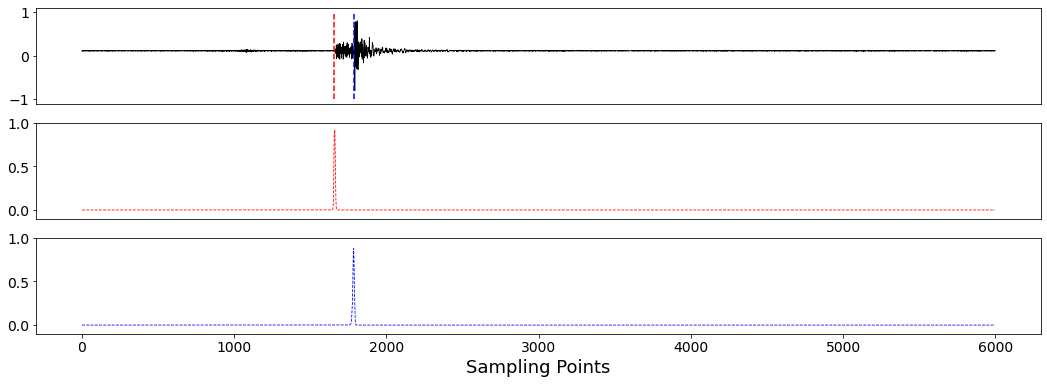

In [8]:
# plot picking result of different traces
chose_TraceID = (3,4);
P_result = pick_result[0,0,:,:,:];
S_result = pick_result[0,1,:,:,:];
pickplot1D(data,P_result,S_result,chose_TraceID,plot_comp='X');

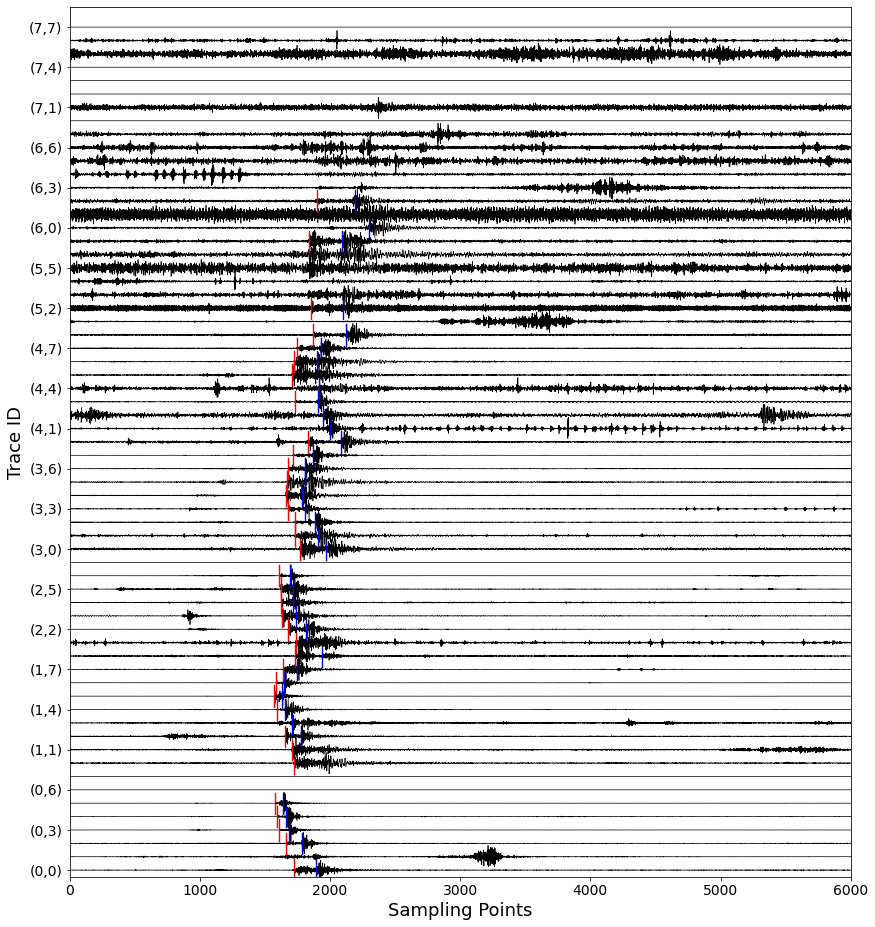

In [9]:
# Pick Result in total
pickplot2D(data,P_result,S_result,plot_comp='Z');